## Scaling The Dataset

In [1]:
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device='cuda' if torch.cuda.is_available() else 'cpu'
data_folder='../data'
# want to download FMNIST to
fmnist=datasets.FashionMNIST(data_folder,download=True,train=True)
tr_images=fmnist.data
tr_targets=fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x=x.float()/255
        x=x.view(-1,28*28)
        self.x,self.y=x,y
    def __getitem__(self, item):
        x,y=self.x[item],self.y[item]
        return x.to(device),y.to(device)
    def __len__(self):
        return len(self.x)

In [3]:
def get_data():
    train=FMNISTDataset(tr_images,tr_targets)
    trn_dl=DataLoader(train,batch_size=32,shuffle=True)
    return trn_dl

In [4]:
def get_model():
    model=nn.Sequential(
        nn.Linear(28*28,1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)
    loss_fn=nn.CrossEntropyLoss()
    optimizer=SGD(model.parameters(),lr=1e-2)
    return model,loss_fn,optimizer

In [5]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    # call your model like any python function on your batch of inputs
    prediction=model(x)
    # compute loss
    batch_loss=loss_fn(prediction,y)
    # based on the forward pass in 'model(x)' compute all the
    # gradients of 'model.parameters()'
    batch_loss.backward()
    # apply new-weights=f(old-weights,old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()
    # Flush memory for next batch of calculations
    opt.zero_grad()
    return batch_loss.item()
@torch.no_grad()
def accuracy(x,y,model):
    model.eval()
    # get the prediction matrix for a tensor of 'x' images
    prediction=model(x)
    # compute if the location of maximum in each row
    # coincides with ground truth
    max_values,argmaxes=prediction.max(-1)
    is_correct=argmaxes==y
    return is_correct.cpu().numpy().tolist()

In [6]:
trn_dl=get_data()
model,loss_fn,optimizer=get_model()
losses,accuracies=[],[]
for epoch in range(5):
    print(epoch)
    epoch_losses,epoch_accuracies=[],[]
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        batch_loss=train_batch(x,y,model,optimizer,loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss=np.array(epoch_losses).mean()
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        is_correct=accuracy(x,y,model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy=np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31436\1019247531.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


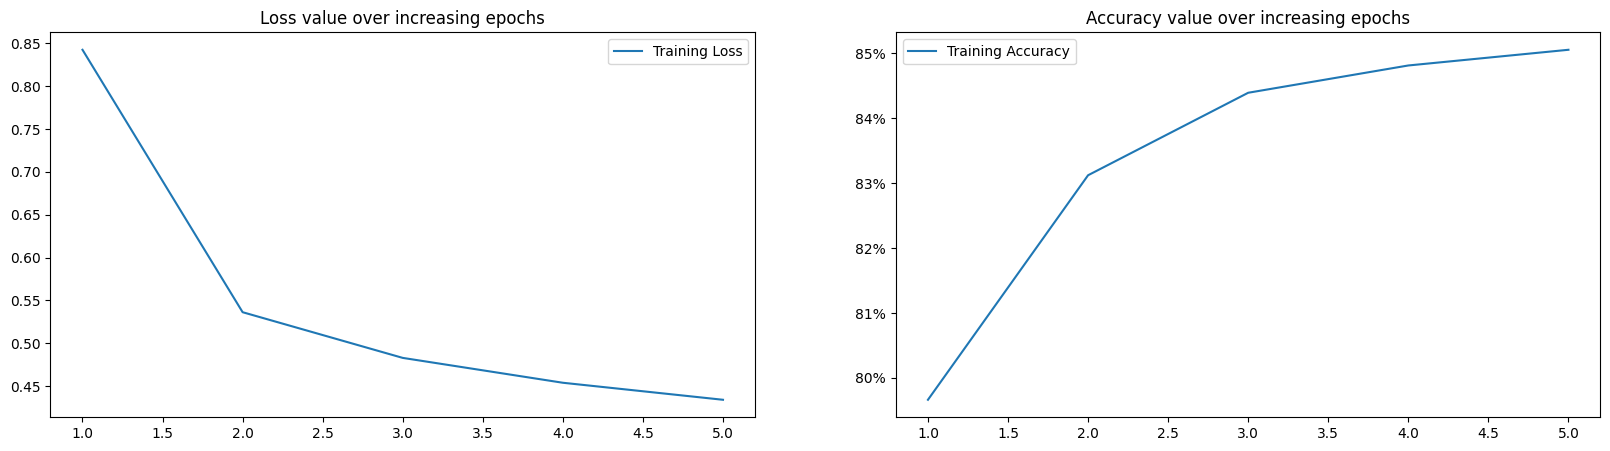

In [7]:
epochs=np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs,losses,label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs,accuracies,label='Training Accuracy')
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])
plt.legend()